# **Sentiment Analysis Project**

In [1]:
import re
from os import path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize as word_tokenize

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Macintosh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **Read in the two datasets**

In [2]:
df_small = pd.read_csv('data_raw/bb/bb_2011_2013.csv')
df_full = pd.read_csv('data_raw/bb/bb_1996_2013.csv', index_col=0)

## **Preview of the two datasets and number of articles in each dataset (number of rows)**

In [3]:
df_small.head()

,year,month,text
0,2011,1,The manufacturing sector continued to recover ...
1,2011,3,Retail spending strengthened compared with a y...
2,2011,4,Consumer spending picked up modestly across mo...
3,2011,6,Consumer spending was generally described as s...
4,2011,7,Consumer spending increased overall in most Di...


In [4]:
df_small.shape

(21, 3)

In [5]:
df_full.head()

,location,year,month,text
1,Richmond,2011,11,district manufacturing activity was little cha...
2,Richmond,2011,10,district manufacturing activity continued to c...
3,Boston,2012,8,first district retail contacts offer a very mi...
4,Boston,2012,2,first district retailers responding in this ro...
5,Boston,2012,1,"as in mid-november, retail contacts for this r..."


In [6]:
df_full.shape

(1608, 4)

## **Example of one of the articles to analyze**

In [7]:
df_small['text'][0]

'The manufacturing sector continued to recover across all Districts. Contacts in the Richmond, Chicago, and St. Louis Districts identified a strong flow of new orders. Respondents in the Chicago District pointed to pent-up demand for both light and heavy motor vehicles, attributed to an aging fleet, as a key driver of activity in the manufacturing sector. The Cleveland District described orders as above expectations and respondents in the New York District noted that orders had picked up since the prior report. Overall, demand was generally characterized as stable and steady, and no District made mention of lingering fears of a double-dip recession, in contrast to the summer reporting periods. Capacity utilization continued to trend higher and is approaching normal rates for some contacts in the Cleveland and San Francisco Districts, while production in high-tech manufacturing was reportedly at high capacity in Dallas; some manufacturers in the St. Louis and Minneapolis Districts said 

## **Read the contents of the lexicon files and combine the data into positive and negative dataframes**

In [8]:
positive_lexicon_files = ["data_raw/lexicons/lexicon.generic.positive.HuLiu.csv",
                          "data_raw/lexicons/lexicon.finance.positive.csv",
                          "data_raw/lexicons/lexicon.finance.positive.LoughranMcDonald.csv"]
negative_lexicon_files = ["data_raw/lexicons/lexicon.generic.negative.HuLiu.csv",
                          "data_raw/lexicons/lexicon.finance.negative.LoughranMcDonald.csv",
                          "data_raw/lexicons/lexicon.finance.negative.csv"]

pos_lexicon_df = pd.DataFrame()
neg_lexicon_df = pd.DataFrame()

In [9]:
for file in positive_lexicon_files:
    df_file = pd.read_csv(file, names=['positive_lexicon'])
    pos_lexicon_df = pd.concat([pos_lexicon_df, df_file])
    
for file in negative_lexicon_files:
    df_file = pd.read_csv(file, encoding='latin_1', names=['negative_lexicon'])
    neg_lexicon_df = pd.concat([neg_lexicon_df, df_file])

## **Preview the positive and negative lexicon dataframes before cleaning**

In [10]:
pos_lexicon_df

,positive_lexicon
0,a+
1,abound
2,abounds
3,abundance
4,abundant
...,...
349,WIN
350,WINNER
351,WINNERS
352,WINNING


In [11]:
neg_lexicon_df

,negative_lexicon
0,2-faced
1,2-faces
2,abnormal
3,abolish
4,abominable
...,...
24,sluggish
25,slowed
26,slowdown
27,slower \t


## **Preview the positive and negative lexicon dataframes after cleaning**

In [12]:
pos_lexicon_df = pos_lexicon_df.apply(lambda x: x.str.lower())
pos_lexicon_df = pos_lexicon_df.apply(lambda x: x.str.replace('\\t', '').replace('\\r', '').replace('`', '').replace('\\n', ''))

In [13]:
pos_lexicon_df

,positive_lexicon
0,a+
1,abound
2,abounds
3,abundance
4,abundant
...,...
349,win
350,winner
351,winners
352,winning


In [14]:
neg_lexicon_df = neg_lexicon_df.apply(lambda x: x.str.lower())
neg_lexicon_df = neg_lexicon_df.apply(lambda x: x.str.replace('\\t', '').replace('\\r', '').replace('`', '').replace('\\n', ''))

In [15]:
neg_lexicon_df

,negative_lexicon
0,2-faced
1,2-faces
2,abnormal
3,abolish
4,abominable
...,...
24,sluggish
25,slowed
26,slowdown
27,slower


## **Function used to determine the score of an article**

In [16]:
def scoreSentiment(data_df, pos_lexicon_df, neg_lexicon_df):
    pos_list = set(pos_lexicon_df['positive_lexicon'])
    neg_list = set(neg_lexicon_df['negative_lexicon'])
    scores = []
    row_num = data_df.index[0]
    for row in data_df.iterrows():
        try:
            text = data_df['text'][row_num]
        except KeyError:
            continue
        row_num += 1
        pos = 0
        neg = 0
        words = []
        text = re.sub(r'[^a-zA-Z\s\'-]', '', text)
        for word in text.split():
            words.append(word)
        # print(str(len(words)) + ' words in the report')
        for word in words:
            if word in pos_list:
                # print('POSITIVE Match:\t' + word)
                pos += 1
            elif word in neg_list:
                # print('NEGATIVE Match:\t' + word)
                neg += 1
        score = pos - neg
        # print('pos:\t' + str(pos) + '\tneg:\t' + str(neg) + '\ttotal:\t' + str(score))
        scores.append(score)
    return scores

## **Plots showing the scores for df_small and df_full**

In [17]:
small_scores = scoreSentiment(df_small, pos_lexicon_df, neg_lexicon_df)
small_scores.sort()

In [18]:
str(small_scores)

'[-15, -10, -4, -3, 1, 2, 3, 7, 9, 9, 10, 10, 13, 13, 15, 16, 16, 20, 23, 26, 34]'

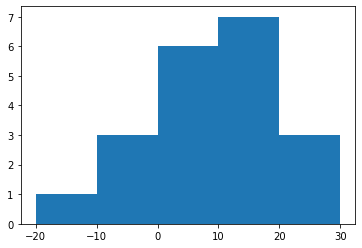

In [19]:
plt.hist(small_scores, bins=range(-20, 40, 10))
plt.show()

In [20]:
full_scores = scoreSentiment(df_full, pos_lexicon_df, neg_lexicon_df)
full_scores.sort()

In [21]:
str(full_scores)

'[-30, -15, -11, -11, -10, -9, -9, -9, -9, -8, -8, -8, -8, -7, -7, -6, -6, -5, -5, -5, -5, -5, -5, -5, -4, -4, -4, -4, -4, -3, -3, -3, -3, -3, -3, -2, -2, -2, -2, -2, -2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 25, 26, 26, 28, 29, 30, 35]'

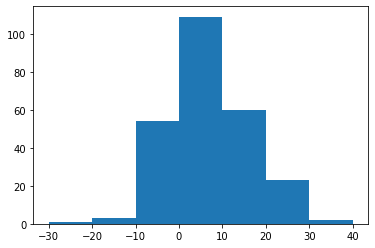

In [22]:
plt.hist(full_scores, bins=range(-30, 50, 10))
plt.show()

## **Combine the contents of df_full**

In [23]:
whole_text = ""
row_num = df_full.index[0]
for row in df_full.iterrows():
    try:
        row_text = df_small['text'][row_num]
    except KeyError:
        continue
    whole_text += row_text
    row_num += 1
print('Length of whole text: \n' + str(len(whole_text)) + '\n')

Length of whole text: 
147075



## **Import the stopwords (words without connotation)**

In [24]:
stopword_files = ["data_raw/stopwords/stopwords.finance.txt",
                  "data_raw/stopwords/stopwords.geographic.txt",
                  "data_raw/stopwords/stopwords.names.txt",
                  "data_raw/stopwords/stopwords.dates.numbers.txt"]

df_stopwords = pd.DataFrame()
for file in stopword_files:
    df_file = pd.read_csv(file, encoding='windows-1252', names=['stopword'])
    df_stopwords = pd.concat([df_stopwords, df_file])

## **Convert stopwords to an array**

In [25]:
df_stopwords = df_stopwords.dropna()
df_stopwords = df_stopwords.apply(lambda x: x.str.lower())
stopwords = list((df_stopwords['stopword']))
stopwords = [s.strip() for s in stopwords]
print('Length of stopwords: \n' + str(len(stopwords)) + '\n')

Length of stopwords: 
13346



## **Add the nltk stopwords**

In [26]:
nltk_stopwords = list(set(nltk.corpus.stopwords.words('english')))
print('Length of nltk_stopwords: \n' + str(len(nltk_stopwords)) + '\n')
stopwords += nltk_stopwords
stopwords = set(stopwords)
print('Length of stopwords containing only unique words: \n' + str(len(stopwords)) + '\n')

Length of nltk_stopwords: 
179

Length of stopwords containing only unique words: 
12315



## **Apply the stemmer (combine words with similar stems)<br></br>E.g. increase and increasing --> increas**

In [27]:
stemmer = SnowballStemmer("english")
words = whole_text.split()
stemmed_words = [stemmer.stem(word) for word in words]
stemmed_words = ' '.join(stemmed_words)
print('Length of whole text: \n' + str(len(whole_text)) + '\n')
print('Length of stemmed text: \n' + str(len(stemmed_words)))

Length of whole text: 
147075

Length of stemmed text: 
133645


## **Filter out the stopwords and show word cloud**

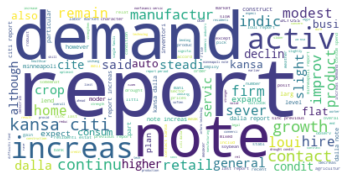

In [28]:
wc = WordCloud(background_color='white', max_words=2000, stopwords=stopwords)
wc.generate(str(stemmed_words))

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()